## Problem statement: <br>
We need to create a model that can accurately predict future stock market prices using machine learning and previous stock market datasets.

**Dataset description:** <br>
In order to model the stock market, we have chosen a dataset from Kaggle with 8,500 files, each containing dense information from all US-based stocks, including ETFs trading on the New York Stock Exchange (NYSE), NASDAQ, and the NYSE MKT: 
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs. <br>
It is difficult but crucial to acquire high-quality data since the results of the model will be largely dependent on the accuracy and validity of the data. Incomplete datasets where there are missing data values for certain values can cause inconsistencies and introduce biases in the model if we have to remove entire instances or give default values to certain attributes. For these reasons, we made sure to find a high-quality financial data set that contains full historical daily price and volume data, last updated on November 10, 2017 by Boris Marjanovic. The dataset includes the following attributes: Date, Open, High, Low, Close, Volume, OpenInt for each stock, where each CSV file contains hundreds of rows – each corresponding to an instance in our dataset which is a single stock. Open represents the opening price, High and Low represent the corresponding maximum and minimum price during the day, Close represents the close price as adjusted for splits, Volume measures the number of shares that exchanges hands throughout the day, and OpenInt to represent Open Interest. Prices have been adjusted to account for dividends and splits.

**Goals:** <br>
Our goal is to build an accurate model that can predict the prices of certain US stocks based on various variables. With high-quality data that will undergo thorough data cleaning through a data processing stage, we want to predict the ups and downs of the stock market and create a well documented model and frontend that is both intuitive and easy for users and developers.

**Timeline:** <br>
Data cleaning/visualization 4/20 <br>
Initial machine learning, training model 4/25 <br>
Improve our model, testing for overfitting/underfitting (QA)  5/1 <br>
Build frontend for model 5/6 <br>
Write documentation for model 5/10 <br>
Test frontend 5/15 <br>
Presentations start 5/31 <br>

The timeline is subject to change based on our availability throughout the quarter. 


In [2]:
# imports
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## Data Cleaning

In [3]:
# import dataset
# we have a few options here: 
# 1. choose a specific industry/sector to look at and then pull stocks/ETFs from that industry to analyze
# 2. choose more broad world/US market ETFs to analyze - VOO, VT, VTI, SPY, QQQ
# 3. choose a few closely related companies (competitors) and analyze them 
# 4. any other suggestions
# semiconductors: NVDA, TSM, QCOM, MU, SMH, AMD, INTC, GFS, MU, MRVL, SLAB, ASML 
# Big tech: MSFT, META, APPL, GOOGL, NFLX, AMZN, UBER, LYFT, QQQ
# SaaS: SNOW, CRM, HUBS, ZM, NOW, WDAY, DDOG. MNDY, SPLK, DBZ, BOX, AI, CFLT, OKTA 
# real estate, healthcare, consumer goods, ecommerce(amazon, walmart, alibaba)
# general market: VOO, VT, VTI 
# look at an index, and look at the companies stocks in that index and look at the etf
# ETF: SPY, 500 companies
# VT as a baseline, 

#path = 'us_etf_stocks_dataset\\'
path = 'E:\\Dataset\\' # Owen's path

voo = pd.read_csv(path + 'ETFs\\voo.us.txt')
vt = pd.read_csv(path + 'ETFs\\vt.us.txt')
vti = pd.read_csv(path + 'ETFs\\vti.us.txt')
spy = pd.read_csv(path + 'ETFs\\spy.us.txt')
qqq = pd.read_csv(path + 'ETFs\\qqq.us.txt')

nvda = pd.read_csv(path + 'Stocks\\nvda.us.txt')

print(nvda[nvda['OpenInt'] != 0].head())
print(voo[voo['OpenInt'] != 0].head())
print(spy[spy['OpenInt'] != 0].head())

print(spy.head())
print(qqq.head())
print(vti.head())

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
         Date    Open    High     Low   Close    Volume  OpenInt
0  2005-02-25  104.77  106.00  104.68  105.79  70221808        0
1  2005-02-28  105.55  105.68  104.56  105.08  79695344        0
2  2005-03-01  105.22  105.87  105.22  105.62  54607412        0
3  2005-03-02  105.21  106.22  105.10  105.57  73733090        0
4  2005-03-03  105.99  106.20  105.15  105.61  71286823        0
         Date    Open    High     Low   Close    Volume  OpenInt
0  1999-03-10  45.722  45.750  44.967  45.665  11700414        0
1  1999-03-11  45.994  46.260  44.988  45.880  21670048        0
2  1999-03-12  45.721  45.749  44.406  44.770  19553768        0
3  1999-03-15  45.101  46.103  44.625  46.052  14245348        0
4  1999-03-16  46.253  46.643  45.74

In [3]:
'''
plt.plot(voo['Date'], voo['Close'], label='VOO')
plt.plot(vt['Date'], vt['Close'], label='VT')
plt.plot(vti['Date'], vti['Close'], label='VTI')
plt.plot(spy['Date'], spy['Close'], label='SPY')
plt.plot(qqq['Date'], qqq['Close'], label='QQQ')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('ETF Closing Prices Over Time')
plt.show()
'''

"\nplt.plot(voo['Date'], voo['Close'], label='VOO')\nplt.plot(vt['Date'], vt['Close'], label='VT')\nplt.plot(vti['Date'], vti['Close'], label='VTI')\nplt.plot(spy['Date'], spy['Close'], label='SPY')\nplt.plot(qqq['Date'], qqq['Close'], label='QQQ')\nplt.legend()\nplt.xlabel('Date')\nplt.ylabel('Closing Price')\nplt.title('ETF Closing Prices Over Time')\nplt.show()\n"

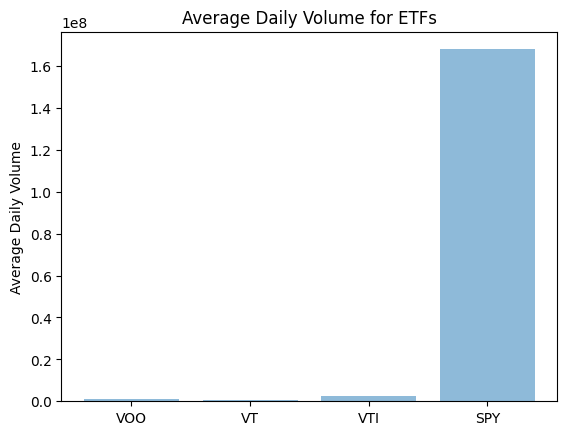

In [4]:
etfs = ['VOO', 'VT', 'VTI', 'SPY']
avg_volumes = [voo['Volume'].mean(), vt['Volume'].mean(), vti['Volume'].mean(), spy['Volume'].mean()]

y_pos = np.arange(len(etfs))

plt.bar(y_pos, avg_volumes, align='center', alpha=0.5)
plt.xticks(y_pos, etfs)
plt.ylabel('Average Daily Volume')
plt.title('Average Daily Volume for ETFs')

plt.show()

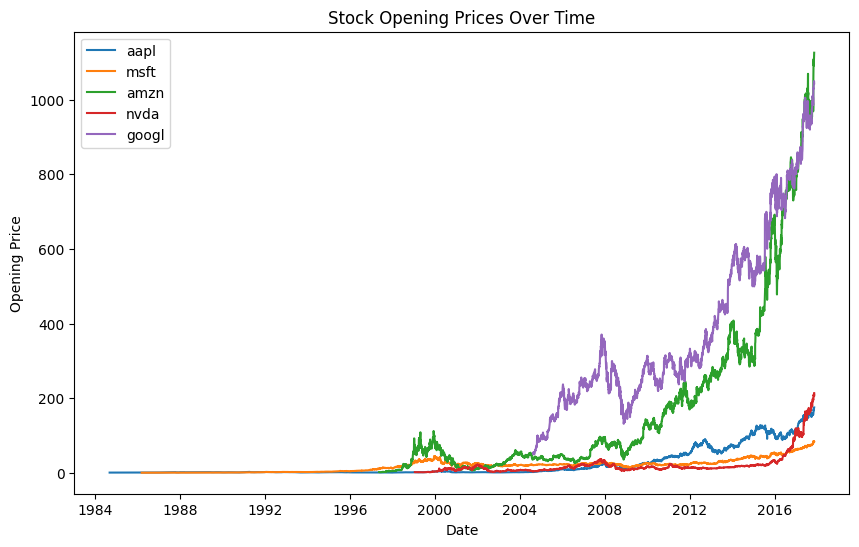

In [4]:
# top 25 companies in SPY (by weight)
spy_companies = ['aapl', 'msft', 'amzn', 'nvda', 'googl', #'brk-b', 'goog', 'fb', 'xom', 'unh', 'tsla', 'jnj', 'jpm', 'v', 
                #'pg', 'ma', 'lly', 'hd', 'cvx', 'mrk', 'abbv', 'pep', 'avgo', 'ko', 'cost'
                ]

def read_stock_data(stock_names):
    stock_data = {}
    for stock in stock_names:
        stock_data[stock] = pd.read_csv(path + f'Stocks\\{stock}.us.txt')
    return stock_data

stock_data = read_stock_data(spy_companies)

# convert 'date' column to datatime objects
for stock_name, data in stock_data.items():
    data['Date'] = pd.to_datetime(data['Date'])

fig = plt.figure(figsize=(10, 6))

for stock_name, data in stock_data.items():
    plt.plot(data['Date'], data['Open'], label=stock_name)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.title('Stock Opening Prices Over Time')
plt.show()

In [6]:
# General preprocessing function for stocks

scaler = MinMaxScaler(feature_range = (0, 1))

def preprocess_data(ticker, training_ratio = 0.8):
    data = stock_data[ticker]
    data = pd.read_csv(path + 'Stocks\\' + ticker + '.us.txt')
    
    # Only use stocks after 2000
    start_date = data['Date'] < '2000-1-1'
    data = data[start_date]
    
    # Use 'Open' column
    data_open = data.iloc[:,1:2].values
    
    # Split data by training ratio
    split = int(len(data_open) * training_ratio)
    
    training_data = data_open[:split]
    testing_data = data_open[split:]
    
    scaled_training_data = scaler.fit_transform(training_data)
    # scaled_testing_data = scaler.fit_transform(testing_data)
    
    X_train = []
    y_train = []

    for i in range(100, split):
        X_train.append(scaled_training_data[i-100:i, 0])
        y_train.append(scaled_training_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    return X_train, y_train, testing_data, data_open

# Apple (aapl)

In [7]:
# Preprocessing
'''
appl_data = stock_data['aapl']
appl_data = pd.read_csv(path + 'Stocks\\aapl.us.txt')
print(appl_data.iloc[len(appl_data)-1])

start_date = appl_data['Date'] < '2000-1-1'
appl_data = appl_data[start_date]
# use'Open' column
appl_open = appl_data.iloc[:,1:2].values

split = int(len(appl_open)*.8)

training_data = appl_open[:split]
testing_data = appl_open[split:]

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_training_data = scaler.fit_transform(training_data)
scaled_testing_data = scaler.fit_transform(testing_data)

#print(training_data)
#print(scaled_training_data)
#print(training_data.shape)

X_train = []
y_train = []

for i in range(100, split):
    X_train.append(scaled_training_data[i-100:i, 0])
    y_train.append(scaled_training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(y_train.shape)
print(X_train.shape)
'''
X_train, y_train, testing_data, aapl_open = preprocess_data('aapl', 0.8)

In [8]:
# Model training

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
99/99 [==============================] - 13s 81ms/step - loss: 0.0195
Epoch 2/50
99/99 [==============================] - 8s 79ms/step - loss: 0.0051
Epoch 3/50
99/99 [==============================] - 8s 83ms/step - loss: 0.0048
Epoch 4/50
99/99 [==============================] - 8s 80ms/step - loss: 0.0039
Epoch 5/50
99/99 [==============================] - 8s 77ms/step - loss: 0.0039
Epoch 6/50
99/99 [==============================] - 9s 89ms/step - loss: 0.0034
Epoch 7/50
99/99 [==============================] - 9s 91ms/step - loss: 0.0032
Epoch 8/50
99/99 [==============================] - 10s 96ms/step - loss: 0.0032
Epoch 9/50
99/99 [==============================] - 8s 82ms/step - loss: 0.0029
Epoch 10/50
99/99 [==============================] - 8s 81ms/step - loss: 0.0027
Epoch 11/50
99/99 [==============================] - 8s 81ms/step - loss: 0.0027
Epoch 12/50
99/99 [==============================] - 9s 96ms/step - loss: 0.0026
Epoch 13/50
99/99 [================

In [10]:
# Computing prediction

inputs = aapl_open

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(100, len(testing_data)):
    X_test.append(testing_data[i-100:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
actual_stock_price = scaler.inverse_transform(testing_data)

23/23 [==============================] - 2s 28ms/step


In [11]:
# MSE of training

train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.0003794697404373437


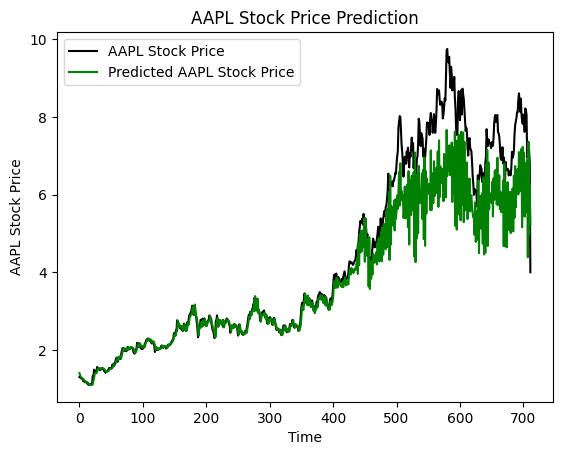

In [12]:
# Plotting

plt.plot(actual_stock_price[100:], color = 'black', label = 'AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

# Microsoft (msft)

In [1]:
# Preprocessing

X_train, y_train, testing_data, msft_open = preprocess_data('msft', 0.8)

NameError: name 'preprocess_data' is not defined

In [30]:
# Model training

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

89/89 [==============================] - 12s 78ms/step - loss: 0.0048


In [31]:
# Computing prediction

inputs = msft_open

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(100, len(testing_data)):
    X_test.append(testing_data[i-100:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
actual_stock_price = scaler.inverse_transform(testing_data)

20/20 [==============================] - 2s 29ms/step


In [32]:
# MSE of training

train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.00021873861260246485


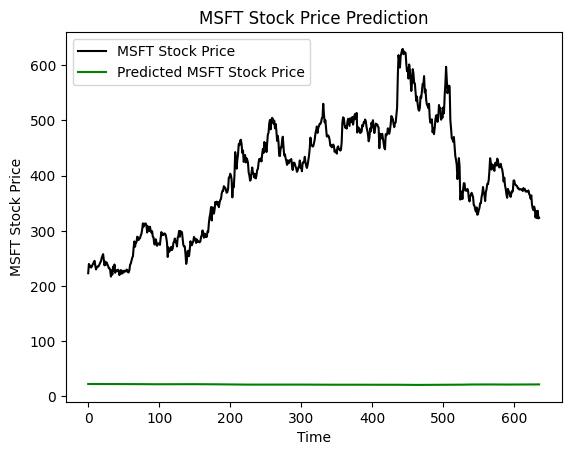

In [29]:
# Plotting

plt.plot(actual_stock_price[100:], color = 'black', label = 'MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()

# Amazon (amzn)

# Nvidia (nvda)

# Google (googl)

In [ ]:
import keras
import tensorflow as tf

print(f'Keras version: {keras.__version__}')
print(f'TensorFlow version: {tf.__version__}')